## Introduction



This tutorial shows how to read/write and plot a SO map. We will use both pixellisation *i.e.* `CAR` and
`HEALPIX` with the same interface showing how `pspy` can deal with both data format.



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Versions used for this tutorial



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pspy, pixell
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    pixell :", pixell.__version__)
print("      pspy :", pspy.__version__)

     Numpy : 1.18.0
Matplotlib : 3.1.2
    pixell : 0.6.0+34.g23be32d
      pspy : 0+untagged.94.ga440ef3.dirty


Get default data dir from `pspy` and set Planck colormap as default



In [3]:
from pspy.so_config import DEFAULT_DATA_DIR
pixell.colorize.mpl_setdefault("planck")

## Generation of CAR and HEALPIX templates



We start with the definition of the `CAR` template, it will go from right ascension `ra0` to `ra1` and
from declination `dec0` to `dec1` (all in degrees). The resolution will be 1 arcminute and we will allow
3 components (stokes parameter in the case of CMB anisotropies)



In [4]:
ra0, ra1, dec0, dec1 = -5, 5, -5, 5
res = 1
ncomp = 3
from pspy import so_map
template_car = so_map.car_template(ncomp, ra0, ra1, dec0, dec1, res)

We do the same with `HEALPIX`



In [5]:
template_healpix = so_map.healpix_template(ncomp, nside=256, coordinate="equ")

## Simulation of CMB data



We first have to compute $C_\ell$ data using a cosmology code such as [CAMB](https://camb.readthedocs.io/en/latest/) and we need to install it
since this is a prerequisite of `pspy`. We can do it within this notebook by executing the following
command



In [6]:
%pip install camb

Note: you may need to restart the kernel to use updated packages.


To make sure everything goes well, we can import `CAMB` and check its version



In [7]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.1.0


Now that `CAMB` is properly installed, we will produce $C_\ell$ data from $\ell$<sub>min</sub>=2 to
$\ell$<sub>max</sub>=10<sup>4</sup> for the following set of $\Lambda$CDM parameters



In [8]:
lmin, lmax = 2, 10**4
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We can plot the results for sanity check



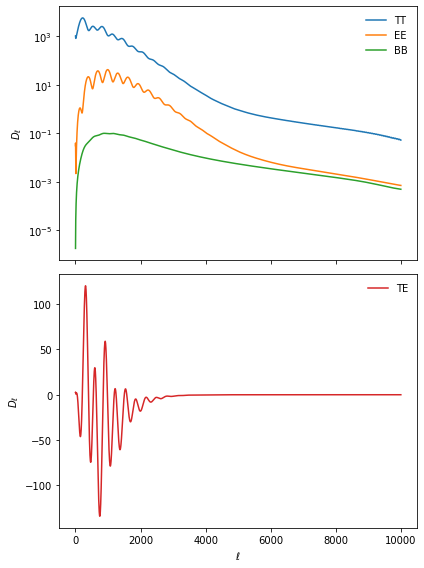

In [9]:
l = np.arange(lmin, lmax)
cl_dict = {spec: powers["total"][lmin:lmax, i]
           for i, spec in enumerate(["tt", "ee", "bb", "te"])}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, (k, v) in enumerate(cl_dict.items()):
    ax = axes[1] if k == "te" else axes[0]
    ax.plot(l, v, "-C{}".format(i), label=k.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
axes[1].set_xlabel(r"$\ell$")
plt.tight_layout()

We finally have to write $C_\ell$ into a file to feed the `so_map.synfast` function for both
pixellisation templates



In [10]:
import os
output_dir = "/tmp/tutorial_io"
os.makedirs(output_dir, exist_ok=True)
cl_file = output_dir + "/cl_camb.dat"
np.savetxt(cl_file,
           np.hstack([l[:, np.newaxis], powers["total"][lmin:lmax]]))
cmb_car = template_car.synfast(cl_file)
cmb_healpix = template_healpix.synfast(cl_file)

We can plot both maps, first for the `CAR` pixellisation



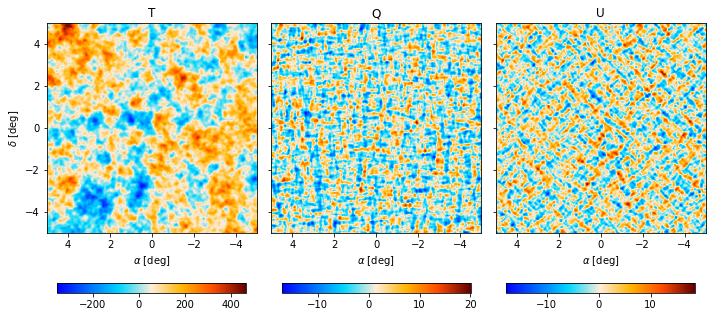

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fields = ["T", "Q", "U"]
kwargs = dict(extent=[ra1, ra0, dec0, dec1], origin="lower")
for i, field in enumerate(fields):
    im = axes[i].imshow(cmb_car.data[i], **kwargs)
    axes[i].set_title(fields[i])
    fig.colorbar(im, ax=axes[i], orientation="horizontal", shrink=0.9)

axes[0].set_ylabel(r"$\delta$ [deg]")
for ax in axes: ax.set_xlabel(r"$\alpha$ [deg]")
plt.tight_layout()

then for the `HEALPIX` pixellisation



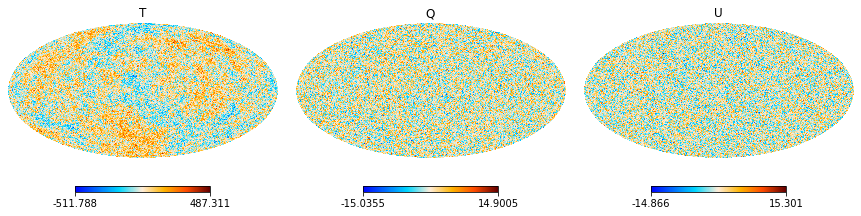

In [12]:
import healpy as hp
plt.figure(figsize=(12,8))
for i, field in enumerate(fields):
    hp.mollview(cmb_healpix.data[i], title=field, sub=(1, ncomp, i+1))

Actually, saving CMB maps can be done with the `so_map.plot` function which can be used interactively
(maps will popup *via* an external image viewer program) but can also be used to store each CMB maps
(T, Q, U) inside a directory as follow



In [13]:
cmb_car.plot(file_name="{}/map_car_io".format(output_dir))
cmb_healpix.plot(file_name="{}/map_healpix_io".format(output_dir))

<Figure size 612x388.8 with 0 Axes>

<Figure size 612x388.8 with 0 Axes>

<Figure size 612x388.8 with 0 Axes>

## Writing/reading SO maps



Maps can also be write to disk in `fits` format with the `so_map.write_map` function



In [14]:
cmb_car.write_map("{}/map_car.fits".format(output_dir))
cmb_healpix.write_map("{}/map_healpix.fits".format(output_dir))

/home/garrido/Workdir/CMB/development/pspy/pyenv/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


We can read them back



In [15]:
cmb_car2 = so_map.read_map("{}/map_car.fits".format(output_dir))
cmb_healpix2 = so_map.read_map("{}/map_healpix.fits".format(output_dir))

/home/garrido/Workdir/CMB/development/pspy/pyenv/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


We null them



In [16]:
cmb_car2.data -= cmb_car.data
cmb_healpix2.data -= cmb_healpix.data

and plot the nulls



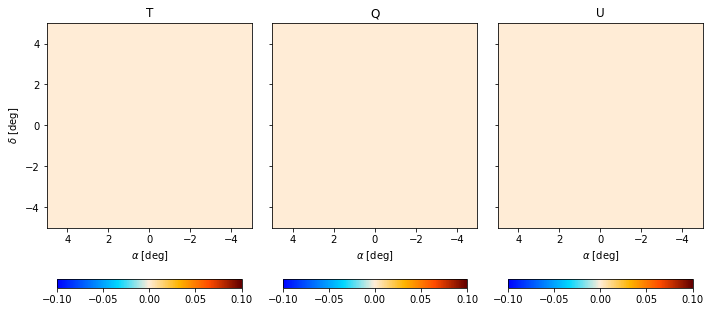

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
for i, field in enumerate(fields):
    im = axes[i].imshow(cmb_car2.data[i], **kwargs)
    axes[i].set_title(fields[i])
    fig.colorbar(im, ax=axes[i], orientation="horizontal", shrink=0.9)

axes[0].set_ylabel(r"$\delta$ [deg]")
for ax in axes: ax.set_xlabel(r"$\alpha$ [deg]")
plt.tight_layout()

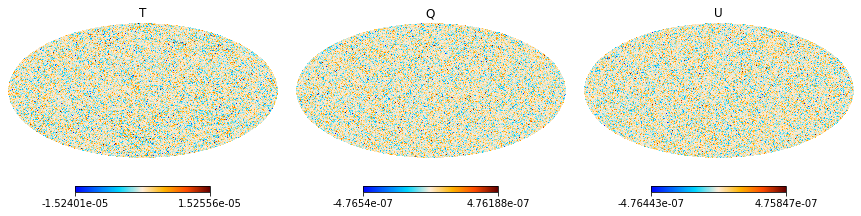

In [18]:
plt.figure(figsize=(12,8))
for i, field in enumerate(fields):
    hp.mollview(cmb_healpix2.data[i], title=field, sub=(1, ncomp, i+1))

Note that while `CAR` is zero, some low amplitude numerical noise is there in `HEALPIX`.



In [19]:
np.allclose(cmb_car2.data, 0), np.allclose(cmb_healpix2.data, 0)

(True, False)